# Przemysław Kaleta
Data: https://data.stanford.edu/hcmst2017

In [490]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import xgboost as xgb

from collections import defaultdict

In [491]:
data = pd.read_stata("hcmts.dta")

Explanations of variable names taken from:

https://stacks.stanford.edu/file/druid:vt073cc9067/HCMST_2017_fresh_Codeboodk_v1.1a.pdf

* Yes/no questions:
    * **Q5** Is [Partner name] the same sex as you? 
    * **Q25_2** Did you and [Partner name] attend the same high school?
    * **Q10** Highest level of schooling of partner
    * **hcm2017q24_met_online** Met online
    
* Quantitative questions:
    * **w6_q9** partner age in 2017
    * **w6_q24_length** length of q24 how met answer in characters

In [492]:
binary_variables = ["Q5", "Q25_2", "Q26_2",  "hcm2017q24_met_online"]
continuous_variables = ["w6_q9", "w6_q24_length"]
predicted_variables = ["S1"]
variables = binary_variables + continuous_variables + predicted_variables
mydata = data.loc[data.S1.notna(), variables]

## Model

In [493]:
# Dictionary with keys as columns of categorical variables 
# and values as functions which for a given code tell us what category it is
name_from_code = defaultdict(lambda: lambda x: x)

# usage: name_from_code["column_name"](code)
# If column name is not in binary variables name_from_code["column_name"] is an identity function.

for column_name in binary_variables + predicted_variables:
    
    column = mydata[column_name].values
    
    def _name_from_code(x, col=column):
        return col.from_codes([x], col.categories)[0]
    
    name_from_code[column_name] = _name_from_code
    
    mydata[column_name] = column.codes
    
colnames = X_train.columns
names_explained_list = ["same_sex", "high_school", "university", "met_online", "partner_age", "w6_q24_length"]
names_explained = {colname: colname_explained for colname, colname_explained in zip(colnames, names_explained_list)}

In [362]:
X, y = mydata.drop("S1", axis=1), mydata["S1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.35,
                max_depth = 5, alpha = 0, n_estimators = 100)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

def test_classifier(y_true, y_pred):
    n = len(y_true)
    print(f"Positive/negative percentages in population: {sum(y_true) / n} / {sum(y_true == 0) / n}")
    print(f"Accuracy {sum(y_true == y_pred) / n}")
    print(f"F1 score: {f1_score(y_true, y_pred)}")
    
test_classifier(y_test, y_pred)

Positive/negative percentages in population: 0.405982905982906 / 0.594017094017094
Accuracy 0.8076923076923077
F1 score: 0.7283702213279677


## LIME

Spróbujemy zastosować metodę LIME do wyjaśnienia predykcji modelu.

#### Osoba 1 

In [363]:
def get_random_person(X):
    random_person = X.iloc[random.choice(range(0, len(X)))]
    random_person = pd.DataFrame([random_person.values], columns=X_train.columns)
    print(random_person)
    print("Predicted probabilities:", xgb_model.predict_proba(random_person))
    for colname, code in zip(random_person.columns, random_person.iloc[0]):
        print(colname, name_from_code[colname](code))
    married = xgb_model.predict(random_person)
    print("S1 - prediction", name_from_code["S1"](married))
    return random_person

random.seed(11)
random_person = get_random_person(X_train)

    Q5  Q25_2  Q26_2  hcm2017q24_met_online  w6_q9  w6_q24_length
0 -1.0   -1.0   -1.0                    0.0   75.0          109.0
Predicted probabilities: [[0.93014497 0.06985502]]
Q5 nan
Q25_2 nan
Q26_2 nan
hcm2017q24_met_online no
w6_q9 75.0
w6_q24_length 109.0
S1 - prediction Index(['Yes, I am Married'], dtype='object')


In [517]:
class Lime:
    def __init__(self, X, model, binary_variables, continuous_variables, observation):
        self.X = X
        self.model = model
        self.binary_variables = binary_variables
        self.continuous_variables = continuous_variables
        self.variables = self.binary_variables + self.continuous_variables
        self.means = {variable: X.mean()[variable] for variable in continuous_variables}
        self.stdevs = {variable: X.std()[variable] for variable in binary_variables + continuous_variables}
        self.mins = {variable: np.quantile(X[variable].dropna(), 0.02, interpolation="higher") for variable in continuous_variables}
        self.maxs = {variable: np.quantile(X[variable].dropna(), 0.98, interpolation="lower") for variable in continuous_variables}
        self.observation = observation.copy()
        
    def perturb_observation(self):
        new_observation = self.observation.copy()
        for variable in continuous_variables:
            new_observation[variable] = np.random.uniform(self.mins[variable], self.maxs[variable])
        for variable in binary_variables:
            new_observation[variable] = random.choice([-1, 0, 1])
        return new_observation
            
    def _generate_perturbed_set(self, N):
        self.perturbed = pd.concat([self.perturb_observation() for _ in range(N)])
        self.perturbed["prediction"] = self.model.predict(self.perturbed)
        
    def _observation_weight(self, perturbed_observation, sigma):
        """
        Defines distance between perturbed observation and original one.
        Since variables may have different magnitudes we divide by standard error.
        Than we compute weight for this observation in weighted regression.
        """
        total_distance = 0
        for variable in self.binary_variables + self.continuous_variables:
            # observation is a data frame with one row
            total_distance += ((perturbed_observation[variable] - self.observation[variable]) / self.stdevs[variable])**2
        return np.exp(-total_distance)
    
    def get_weights(self, sigma):
        return self.perturbed.apply(lambda x: self._observation_weight(x, sigma), axis=1)[0].values
            
    def fit_simple_model(self, sigma=1):
        from sklearn.linear_model import SGDClassifier
        simple_model = SGDClassifier()
        simple_model.fit(self.perturbed.loc[:, self.binary_variables + self.continuous_variables], self.perturbed["prediction"].values, sample_weight=self.get_weights(sigme))
        self.coef = simple_model.coef_[0]
        
    def plot_simple_model(self):
        print(self.variables)
        plt.bar([names_explained[name] for name in self.variables], self.coef)
        

In [507]:
lime = Lime(X_train, xgb_model, binary_variables, continuous_variables, random_person)

In [509]:
lime._generate_perturbed_set(100)

In [510]:
lime._observation_weight(new_person, 1)

0    0.465599
Name: Q5, dtype: float64

In [511]:
from sklearn.linear_model import SGDClassifier
simple_model = SGDClassifier()
simple_model.fit(lime.perturbed.loc[:, lime.binary_variables + lime.continuous_variables], lime.perturbed["prediction"].values, sample_weight=lime.get_weights(1))

/home/przemyslaw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [512]:
simple_model.coef_

array([[ 2.33941290e-03,  2.65528459e-02,  2.04379785e-03,
        -1.04750654e-02,  1.90064612e-01,  2.50097206e+00]])

In [513]:
lime.fit_simple_model()

/home/przemyslaw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [514]:
random_person

,Q5,Q25_2,Q26_2,hcm2017q24_met_online,w6_q9,w6_q24_length
0,-1.0,-1.0,-1.0,0.0,75.0,109.0


['Q5', 'Q25_2', 'Q26_2', 'hcm2017q24_met_online', 'w6_q9', 'w6_q24_length']


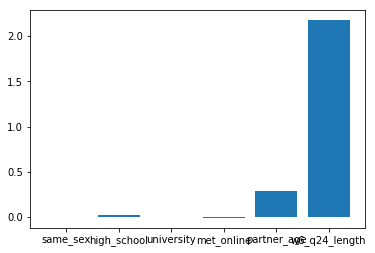

In [515]:
lime.plot_simple_model()

In [503]:
lime.coef

array([-4.68331888e-02,  2.84864919e-01, -4.74417904e-02, -2.20646202e-03,
        2.55783571e+00, -1.24371446e+00])

In [488]:
lime.variables

['Q5', 'Q25_2', 'Q26_2', 'hcm2017q24_met_online', 'w6_q9', 'w6_q24_length']